# Synthetic images segmentation Task

Since the generated images are without labels 

## IMPORTS

In [ ]:
import sys

sys.path.append(r"C:\Users\fede6\Desktop\AI_R")
sys.path.append(r"C:\Users\fede6\Desktop\AI_R\Formazione\Exercises\CV")

In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T
import segmentation_models_pytorch as smp

from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## GLOBALS

In [ ]:
batch_size = 8
path = r"C:\Users\fede6\Desktop\AI_R\DatasetCV"
csv_path = r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\file_paths_new.csv"

## UTILS

In [ ]:
COLORMAP = [
    (255, 192, 203),  
    (100, 149, 237),  
    (34, 139, 34),    
    (194, 197, 204),  
    (88, 57, 39),     
    (0, 163, 108),    
    (250, 213, 165),  
]

sharpen_kernel = np.array([[0, -1,  0],
                           [-1, 5, -1],
                           [0, -1,  0]])

RGB_TO_CLASS = {rgb: idx for idx, rgb in enumerate(COLORMAP)}

def rgb_to_mask(mask):
    h, w, _ = mask.shape
    mask_out = np.zeros((h, w), dtype=np.uint8)
    for idx, color in enumerate(COLORMAP):
        match = np.all(mask == color, axis=-1)
        mask_out[match] = idx
    return mask_out

colormap = np.array(COLORMAP, np.uint8)

def decode_segmap(mask):
    return colormap[mask]

def show_sample(img_tensor, mask_true, mask_pred=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    mask_true_rgb = decode_segmap(mask_true.cpu().numpy())
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title('Input'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(mask_true_rgb); plt.title('Ground Truth'); plt.axis('off')

    if mask_pred is not None:
        mask_pred_rgb = decode_segmap(mask_pred.cpu().numpy())
        plt.subplot(1, 3, 3); plt.imshow(mask_pred_rgb); plt.title('Prediction'); plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def preprocess_cv2_image(image_bgr):
    # --- RGB conversion ---
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = image_rgb.astype(np.float32) / 255.0
    
    # --- Sharpening ---
    image_rgb = cv2.filter2D(image_rgb, -1, sharpen_kernel)

    # --- Saturation increasing ---
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2HSV).astype("float32")
    h, s, v = cv2.split(hsv)
    s *= 2.5
    s = np.clip(s, 0, 255)

    hsv_desat = cv2.merge([h, s, v]).astype("uint8")
    image_rgb = cv2.cvtColor(hsv_desat, cv2.COLOR_HSV2BGR)

    # --- Normalization ---
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_norm = (image_rgb - mean) / std

    # --- Tensor conversion ---
    image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).float()
    return image_tensor

def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in enumerate(COLORMAP):
        color_mask[mask == class_id] = color

    return color_mask

def process_and_save_predictions_pil(model, csv_path, device, output_dir, base_path=path):
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(csv_path, header=0)

    model.eval()

    for idx, row in df.iterrows():
        img_path = os.path.join(base_path, row['filepath'])
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            print(f"ERROR: {img_path}")
            continue

        img_tensor = preprocess_cv2_image(image_bgr).to(device)

        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        pred_mask_rgb = decode_segmap(pred)

        filename = os.path.basename(img_path).replace('.png', '_segmented.png')
        output_path = os.path.join(output_dir, filename)
        Image.fromarray(pred_mask_rgb).save(output_path)

## DATA

In [ ]:
class SegDataset(Dataset):
    def __init__(self, df, path, size=256, transform=True, is_test=False, augmentation=False):
        super(SegDataset, self).__init__()
        self.size = size
        self.path = path
        self.transform = transform
        self.augmentation = augmentation
        self.is_test = is_test

        self.train_df, self.test_df = self._splitter(df)
        self.df = self.test_df if is_test else self.train_df

        self.img_paths = [os.path.join(path, row['bingmap']) for _, row in self.df.iterrows()]
        self.mask_paths = [os.path.join(path, row['segformer']) for _, row in self.df.iterrows()]

        self.img_transform = T.Compose([
            T.ToTensor(),
            T.Resize((self.size, self.size)),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        self.aug_transform = T.Compose([
            T.RandomHorizontalFlip(0.5)
        ]) if augmentation else None

    def _splitter(self, df):
        dim = int(0.7 * len(df))
        return df[:dim], df[dim:]

    def __getitem__(self, index):
        img = cv2.imread(self.img_paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))

        mask = cv2.imread(self.mask_paths[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (self.size, self.size))

        # --- Mask conversion ---
        mask = rgb_to_mask(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        if self.augmentation and self.aug_transform:
            img_pil = T.ToPILImage()(torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.)
            img = self.aug_transform(img_pil)

        img = self.img_transform(img)

        return img, mask

    def __len__(self):
        return len(self.img_paths)

In [ ]:
df = pd.read_csv(csv_path, sep="\t", names=['bingmap', 'streetview', 'sift_bm', 'sift_sv', 'depth_bm', 'depth_sv', 'segmap_bm', 'segmap_sv', 'segformer', 'bool'], encoding='utf-8', header=None)

data_set = SegDataset(df, path, transform=True, size=256, is_test=False)                    
test_set = SegDataset(df, path, transform=True, size=256, is_test=True)                     
gen = torch.Generator().manual_seed(42)                                                     
valid_set, test_set = torch.utils.data.random_split(test_set, [0.5, 0.5], generator=gen)    
train_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)                    
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)                  

## NETWORK

In [3]:
class SegUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):
        super(SegUNet, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_channels,
            activation=None
        )

    def forward(self, x):
        return self.model(x)

## TRAIN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegUNet(in_channels=3, out_channels=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
path = r"C:\Users\fede6\Desktop\AI_R\Formazione\Exercises\CV\seg_models"

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader, desc='Train'):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs) 
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc='Validate'):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy().ravel()
            labs = masks.cpu().numpy().ravel()
            all_preds.append(preds)
            all_labels.append(labs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return {
        'val_loss': running_loss / len(loader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'f1_score': f1_score(all_labels, all_preds, average='macro', zero_division=0)
    }

history = {'train_loss':[], 'val_loss':[], 'accuracy':[], 'precision':[], 'recall':[], 'f1_score':[]}
for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    tl = train_one_epoch(model, train_loader)
    metrics = validate(model, valid_loader)
    history['train_loss'].append(tl)
    for k in ['val_loss','accuracy','precision','recall','f1_score']:
        history[k].append(metrics[k])
    print(f"Train loss: {tl:.4f}")
    print(f"Val loss: {metrics['val_loss']:.4f} | Acc: {metrics['accuracy']:.4f} | "
          f"P: {metrics['precision']:.4f} | R: {metrics['recall']:.4f} | F1: {metrics['f1_score']:.4f}")
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': tl,
        'val_loss': metrics['val_loss'],
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score']
    }

    torch.save(checkpoint, os.path.join(path, f"checkpoint_{epoch + 1}.pt"))


=== Epoch 1/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  3.99it/s]


Train loss: 1.1239
Val loss: 0.8473 | Acc: 0.6746 | P: 0.3781 | R: 0.3844 | F1: 0.3810

=== Epoch 2/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.01it/s]


Train loss: 0.8803
Val loss: 0.7917 | Acc: 0.6906 | P: 0.3857 | R: 0.3980 | F1: 0.3912

=== Epoch 3/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.01it/s]


Train loss: 0.8146
Val loss: 0.8049 | Acc: 0.6800 | P: 0.3986 | R: 0.3731 | F1: 0.3807

=== Epoch 4/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:42<00:00,  3.95it/s]


Train loss: 0.7663
Val loss: 0.7835 | Acc: 0.6910 | P: 0.4563 | R: 0.3933 | F1: 0.3993

=== Epoch 5/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.01it/s]


Train loss: 0.7048
Val loss: 0.7680 | Acc: 0.7001 | P: 0.4663 | R: 0.4416 | F1: 0.4511

=== Epoch 6/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.02it/s]


Train loss: 0.6559
Val loss: 0.7672 | Acc: 0.7009 | P: 0.4679 | R: 0.4272 | F1: 0.4363

=== Epoch 7/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.03it/s]


Train loss: 0.5901
Val loss: 0.7889 | Acc: 0.6967 | P: 0.4534 | R: 0.4457 | F1: 0.4486

=== Epoch 8/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.00it/s]


Train loss: 0.5540
Val loss: 0.8159 | Acc: 0.6967 | P: 0.4551 | R: 0.4422 | F1: 0.4461

=== Epoch 9/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  4.00it/s]


Train loss: 0.5102
Val loss: 0.8040 | Acc: 0.6958 | P: 0.4658 | R: 0.4478 | F1: 0.4551

=== Epoch 10/10 ===


Validate: 100%|███████████████████████████████████████████████████████████| 167/167 [00:41<00:00,  3.99it/s]


Train loss: 0.4846
Val loss: 0.8451 | Acc: 0.6953 | P: 0.4913 | R: 0.4334 | F1: 0.4465


### Visual Evaluation

In [15]:
# --- INFERENCE + VISUALIZATION ---
def visualize_prediction(model, dataset, device, num_samples=10):
    model.eval()
    for i in range(num_samples):
        img, mask = dataset[i]
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            pred = torch.argmax(output, dim=1).squeeze().cpu()
        show_sample(img, mask, pred)

In [22]:
checkpoint = torch.load(r"C:\Users\fede6\Desktop\AI_R\Formazione\Exercises\CV\seg_models\checkpoint_5.pt")

model = SegUNet(in_channels=3, out_channels=7).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\fede6\AppData\Local\Temp\ipykernel_10764\3411900899.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\fede6\Desktop\AI_R\Formaz

<All keys matched successfully>

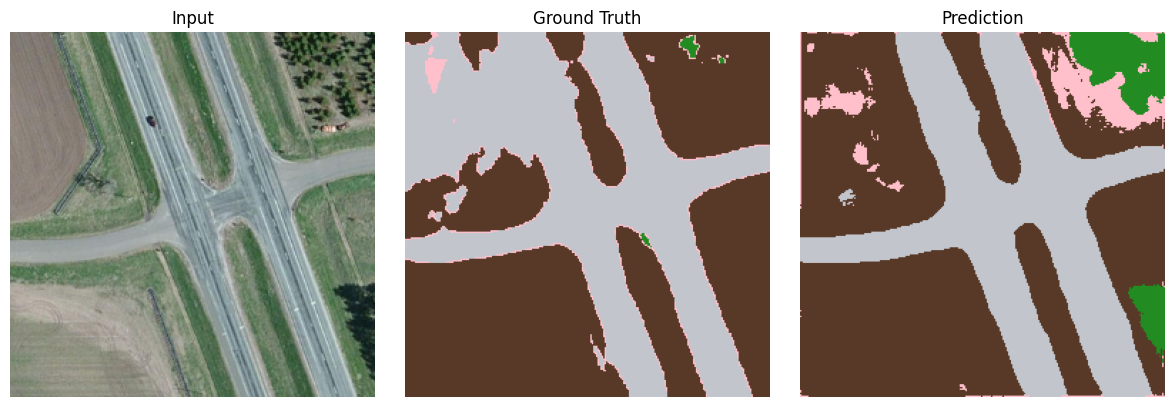

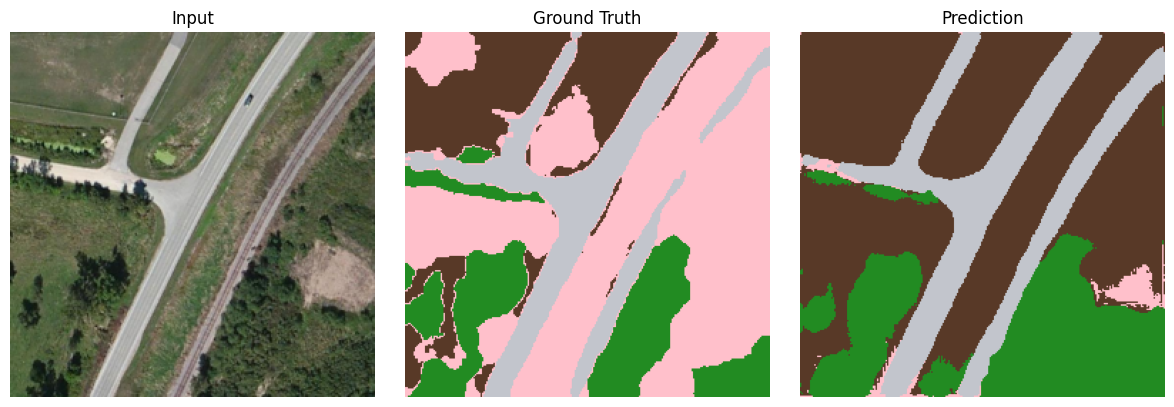

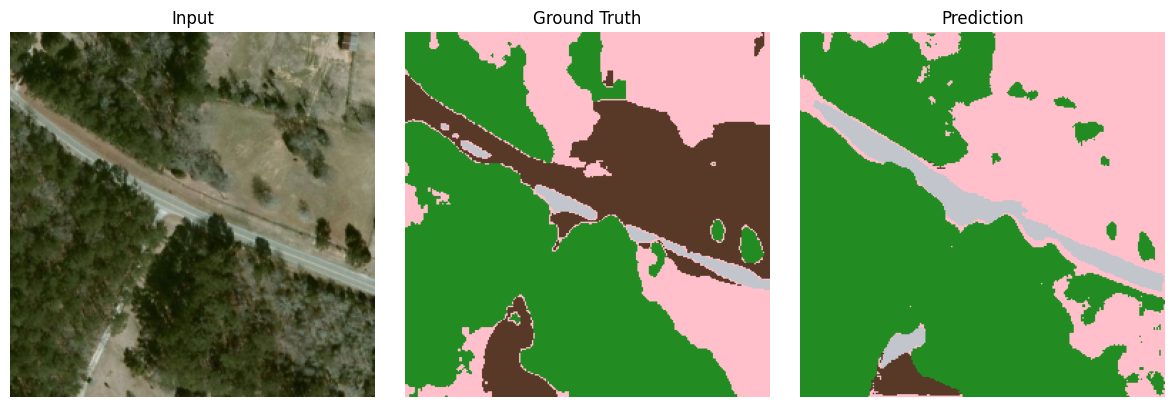

In [23]:
visualize_prediction(model, test_set, device, num_samples=3)

## GENERATION

In [76]:
process_and_save_predictions_pil(model, csv_path=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\BLURRED_name_test.csv", device=device, output_dir=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\TEST_SEGMENTED")
# For train :      BLURRED_name_train.csv | TRAIN_SEGMENTED
# For validation : BLURRED_name_val.csv   | VAL_SEGMENTED

In [ ]:
path = r"C:\Users\fede6\Desktop\AI_R\Formazione\Exercises\CV\SegUNet.pt"

checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }

torch.save(checkpoint, path)

### Visualization

In [3]:
def show_images(path1, path2, titles=('title_1', 'title_2')):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    if img1 is None or img2 is None:
        raise FileNotFoundError("Image not found")

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title(titles[0])
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(titles[1])
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

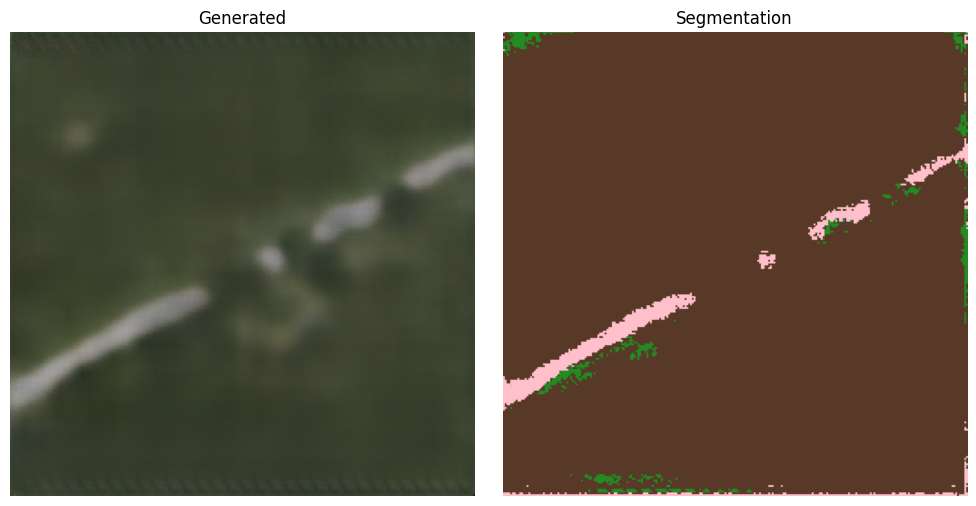

In [4]:
show_images(path1=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\BLURRED_name_test\0000169_generated.png", path2=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\TEST_SEGMENTED_2_5\0000169_generated_segmented.png", titles=('Generated', 'Segmentation'))